In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt

In [2]:
class CrossEntropyAgent:
    def __init__(self, env, state_n, action_n):
        self.env = env
        self.state_n = state_n
        self.action_n = action_n
        self.model = np.ones((state_n, action_n)) / action_n

    def predict(self, state):
        return np.random.choice(np.arange(self.action_n), p=self.model[state])

    def _get_state(self, obs):
        return obs

    def _get_trajectory(self, max_len=1000):
        trajectory = {'states': [], 'actions': [], 'rewards': []}
        obs = self.env.reset()
        state = self._get_state(obs)
        for _ in range(max_len):
            trajectory['states'].append(state)
            action = self.predict(state)
            trajectory['actions'].append(action)
            next_state, reward, done, _ = self.env.step(action)
            trajectory['rewards'].append(reward)
            state = self._get_state(next_state)
            if done:
                break
        return trajectory

    def _update_policy(self, elite_trajectories, smoothing=None, alpha=0.1):
        new_model = np.zeros((self.state_n, self.action_n))
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                new_model[state][action] += 1
        if smoothing == "laplace":
            new_model = (new_model + 0.1) / (new_model.sum(axis=1, keepdims=True) + 0.1*self.action_n)
        elif smoothing == "policy":
            new_model = (1 - alpha) * self.model + alpha * new_model

        for state in range(self.state_n):
            if np.sum(new_model[state]) > 0:
                new_model[state] /= np.sum(new_model[state])
            else:
                new_model[state] = self.model[state].copy()
        self.model = new_model

    def fit(self, iteration=100, trajectory_n=50, q_param=0.4, smoothing=None):
        all_rewards = []
        for i in range(iteration):
            trajectories = [self._get_trajectory() for _ in range(trajectory_n)]
            total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
            print('iteration: ', i, 'mean_rewards: ', np.mean(total_rewards))
            quantile = np.quantile(total_rewards, q_param)
            elite_trajectories = [trajectory for trajectory in trajectories if np.sum(trajectory['rewards']) > quantile]
            all_rewards.append(np.mean(total_rewards))
            self._update_policy(elite_trajectories, smoothing)
        return all_rewards

In [3]:
def get_trajectory(env, agent, max_len=1000, visualize=False):
    trajectory = {'states': [], 'actions': [], 'rewards': []}
    obs = env.reset()
    state = obs
    for _ in range(max_len):
        trajectory['states'].append(state)
        action = agent.predict(state)
        trajectory['actions'].append(action)
        next_state, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)
        state = next_state
        if visualize:
            env.render()
        if done:
            break
    return trajectory

In [4]:
def grid_search(env):
    iterations = [50, 100]
    trajectory_ns = [20, 50, 70]
    q_params = [0.2, 0.4, 0.6]

    best_rewards = -np.inf
    best_params = None
    for iteration in iterations:
        for trajectory_n in trajectory_ns:
            for q_param in q_params:
                agent = CrossEntropyAgent(env, state_n=500, action_n=6)
                rewards = agent.fit(iteration=iteration, trajectory_n=trajectory_n, q_param=q_param)

                if np.mean(rewards) > best_rewards:
                    best_rewards = np.mean(rewards)
                    best_params = (iteration, trajectory_n, q_param)

    print("Best Hyperparameters: ")
    print("Iterations: ", best_params[0])
    print("Trajectory_n: ", best_params[1])
    print("Q_param: ", best_params[2])
    return best_params

In [5]:
if __name__ == "__main__":
    env = gym.make("Taxi-v3").env

Best Hyperparameters:
* Iterations:  100
* Trajectory_n:  70
* Q_param:  0.4

No Smoothing:
  - Max reward reached: 15
  - Average reward: -114.43
  - Final reward: 6
-----
Laplace Smoothing:
  - Max reward reached: -67
  - Average reward: -765.23
  - Final reward: -670
-----
Policy Smoothing:
  - Max reward reached: 13
  - Average reward: -143.7
  - Final reward: 4
-----

iteration:  0 mean_rewards:  -3310.214285714286
iteration:  1 mean_rewards:  -2567.957142857143
iteration:  2 mean_rewards:  -1723.0285714285715
iteration:  3 mean_rewards:  -850.3714285714286
iteration:  4 mean_rewards:  -593.5142857142857
iteration:  5 mean_rewards:  -351.22857142857146
iteration:  6 mean_rewards:  -233.64285714285714
iteration:  7 mean_rewards:  -167.24285714285713
iteration:  8 mean_rewards:  -104.98571428571428
iteration:  9 mean_rewards:  -79.21428571428571
iteration:  10 mean_rewards:  -61.77142857142857
iteration:  11 mean_rewards:  -53.42857142857143
iteration:  12 mean_rewards:  -36.52857142857143
iteration:  13 mean_rewards:  -20.414285714285715
iteration:  14 mean_rewards:  -14.528571428571428
iteration:  15 mean_rewards:  -11.585714285714285
iteration:  16 mean_rewards:  -16.057142857142857
iteration:  17 mean_rewards:  -5.114285714285714
iteration:  18 mean_rewards:  -2.742857142857143
iteration:  19 mean_rewards:  -2.5428571428571427
iteration:  20 mean_

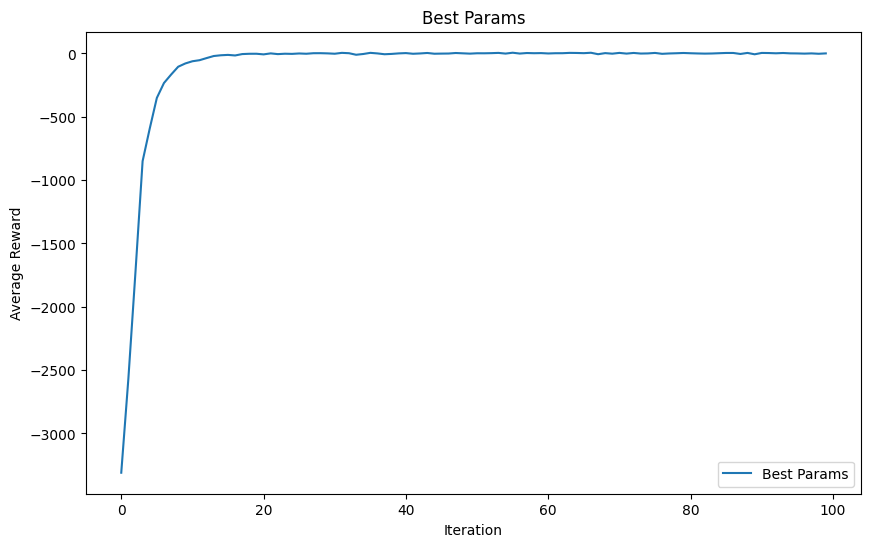

In [6]:
best_params = [100, 70, 0.4]
best_agent = CrossEntropyAgent(env, state_n=500, action_n=6)
best_rewards = best_agent.fit(iteration=100, trajectory_n=70, q_param=0.4)

plt.figure(figsize=(10,6))
plt.plot(best_rewards, label="Best Params")
plt.xlabel("Iteration")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Best Params")
plt.show()

iteration:  0 mean_rewards:  -3194.0285714285715
iteration:  1 mean_rewards:  -2497.657142857143
iteration:  2 mean_rewards:  -1509.4571428571428
iteration:  3 mean_rewards:  -845.9142857142857
iteration:  4 mean_rewards:  -512.5142857142857
iteration:  5 mean_rewards:  -288.9714285714286
iteration:  6 mean_rewards:  -281.8857142857143
iteration:  7 mean_rewards:  -222.14285714285714
iteration:  8 mean_rewards:  -268.24285714285713
iteration:  9 mean_rewards:  -260.1
iteration:  10 mean_rewards:  -298.0857142857143
iteration:  11 mean_rewards:  -315.45714285714286
iteration:  12 mean_rewards:  -389.98571428571427
iteration:  13 mean_rewards:  -293.35714285714283
iteration:  14 mean_rewards:  -421.48571428571427
iteration:  15 mean_rewards:  -391.9142857142857
iteration:  16 mean_rewards:  -335.7
iteration:  17 mean_rewards:  -299.5
iteration:  18 mean_rewards:  -335.57142857142856
iteration:  19 mean_rewards:  -795.0142857142857
iteration:  20 mean_rewards:  -583.8714285714286
iteratio

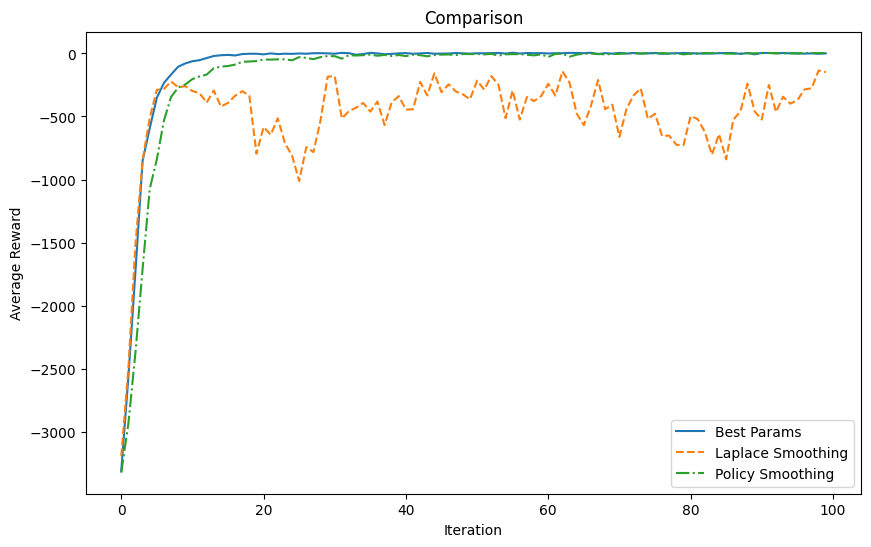

In [7]:
laplace_agent = CrossEntropyAgent(env, state_n=500, action_n=6)
laplace_rewards = laplace_agent.fit(iteration=best_params[0], trajectory_n=best_params[1], q_param=best_params[2], smoothing="laplace")

policy_agent = CrossEntropyAgent(env, state_n=500, action_n=6)
policy_rewards = policy_agent.fit(iteration=best_params[0], trajectory_n=best_params[1], q_param=best_params[2], smoothing="policy")
plt.figure(figsize=(10,6))
plt.plot(best_rewards, label="Best Params")
plt.plot(laplace_rewards, label="Laplace Smoothing", linestyle="--")
plt.plot(policy_rewards, label="Policy Smoothing", linestyle="-.")
plt.xlabel("Iteration")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Comparison")
plt.show()

In [8]:
class StochasticCrossEntropyAgent(CrossEntropyAgent):
    def __init__(self, env, state_n, action_n):
        super().__init__(env, state_n, action_n)

    def _get_trajectory(self, max_len=1000):
        trajectory = {'states': [], 'actions': [], 'rewards': []}
        obs = self.env.reset()
        state = self._get_state(obs)
        for _ in range(max_len):
            trajectory['states'].append(state)
            action = self.predict(state)
            trajectory['actions'].append(action)
            next_state, reward, done, _ = self.env.step(action)
            trajectory['rewards'].append(reward)
            state = self._get_state(next_state)
            if done:
                break
        return trajectory

    def fit(self, iteration=100, trajectory_n=50, q_param=0.4, smoothing=None, M=5, K=10):
        all_rewards = []
        for i in range(iteration):
            sampled_trajectories = []
            total_rewards = []

            for _ in range(M):
                trajectories = [self._get_trajectory() for _ in range(trajectory_n)]
                sampled_trajectories.extend(trajectories)
                total_rewards.extend([np.sum(trajectory['rewards']) for trajectory in trajectories])

            quantile = np.quantile(total_rewards, q_param)
            elite_trajectories = [trajectory for trajectory, total_reward in zip(sampled_trajectories, total_rewards) if total_reward > quantile]

            print('iteration:', i, 'mean_rewards:', np.mean(total_rewards))
            all_rewards.append(np.mean(total_rewards))
            self._update_policy(elite_trajectories, smoothing)

        return all_rewards

iteration: 0 mean_rewards: -3317.8914285714286
iteration: 1 mean_rewards: -2469.7
iteration: 2 mean_rewards: -1426.9714285714285
iteration: 3 mean_rewards: -664.24
iteration: 4 mean_rewards: -344.39714285714285
iteration: 5 mean_rewards: -200.0
iteration: 6 mean_rewards: -110.88857142857142
iteration: 7 mean_rewards: -59.962857142857146
iteration: 8 mean_rewards: -34.997142857142855
iteration: 9 mean_rewards: -17.71142857142857
iteration: 10 mean_rewards: -6.225714285714286
iteration: 11 mean_rewards: 0.8457142857142858
iteration: 12 mean_rewards: 1.72
iteration: 13 mean_rewards: 4.982857142857143
iteration: 14 mean_rewards: 5.094285714285714
iteration: 15 mean_rewards: 2.6342857142857143
iteration: 16 mean_rewards: 5.722857142857142
iteration: 17 mean_rewards: 4.928571428571429
iteration: 18 mean_rewards: 4.708571428571428
iteration: 19 mean_rewards: 5.594285714285714
iteration: 20 mean_rewards: 5.394285714285714
iteration: 21 mean_rewards: 6.102857142857143
iteration: 22 mean_rewards

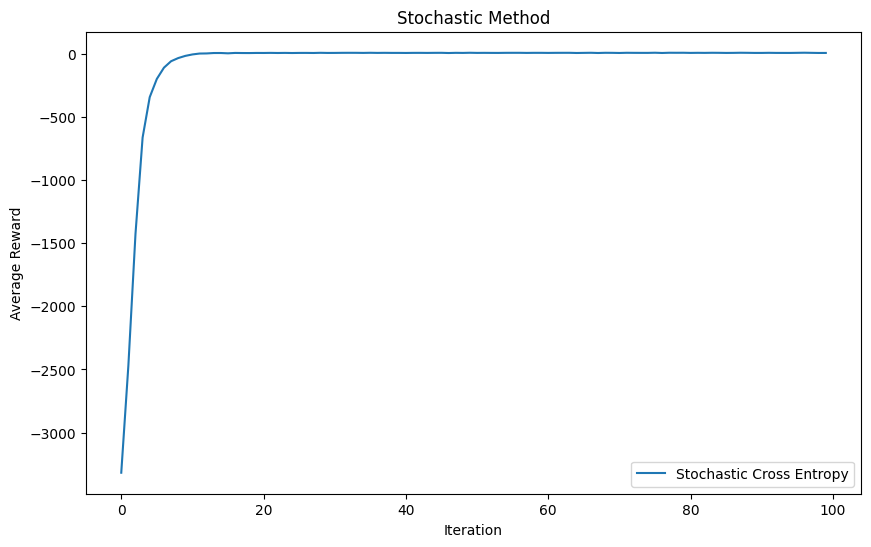

In [9]:
stochastic_agent = StochasticCrossEntropyAgent(env, state_n=500, action_n=6)
stochastic_rewards = stochastic_agent.fit(iteration=100, trajectory_n=70, q_param=0.5)
plt.figure(figsize=(10,6))
plt.plot(stochastic_rewards, label="Stochastic Cross Entropy")
plt.xlabel("Iteration")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Stochastic Method")
plt.show()

iteration:  0 mean_rewards:  -3364.9857142857145
iteration:  1 mean_rewards:  -2618.5142857142855
iteration:  2 mean_rewards:  -2009.5285714285715
iteration:  3 mean_rewards:  -910.7
iteration:  4 mean_rewards:  -586.3
iteration:  5 mean_rewards:  -340.62857142857143
iteration:  6 mean_rewards:  -264.22857142857146
iteration:  7 mean_rewards:  -198.05714285714285
iteration:  8 mean_rewards:  -360.0
iteration:  9 mean_rewards:  -311.72857142857146
iteration:  10 mean_rewards:  -214.24285714285713
iteration:  11 mean_rewards:  -201.3
iteration:  12 mean_rewards:  -136.4857142857143
iteration:  13 mean_rewards:  -277.9714285714286
iteration:  14 mean_rewards:  -130.21428571428572
iteration:  15 mean_rewards:  -184.88571428571427
iteration:  16 mean_rewards:  -632.5857142857143
iteration:  17 mean_rewards:  -354.54285714285714
iteration:  18 mean_rewards:  -575.0571428571428
iteration:  19 mean_rewards:  -435.3285714285714
iteration:  20 mean_rewards:  -249.54285714285714
iteration:  21 me

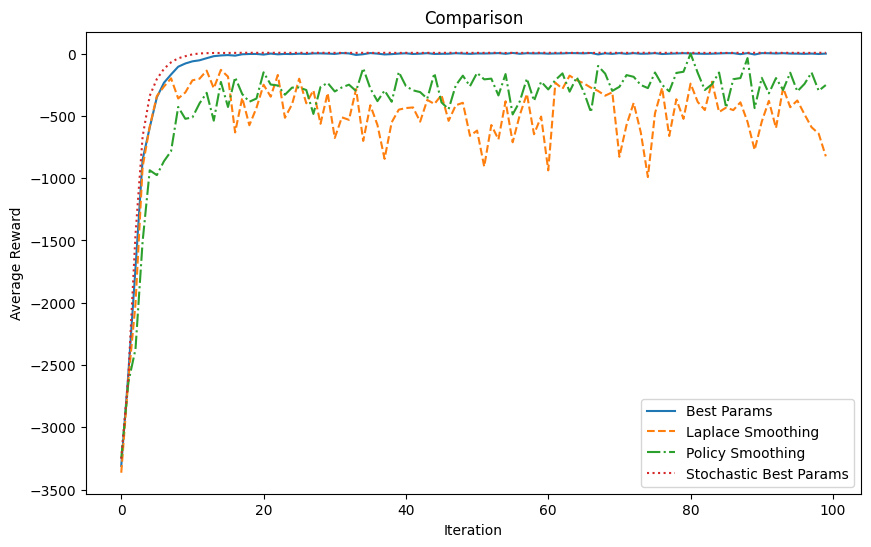

In [10]:
laplace_agent = CrossEntropyAgent(env, state_n=500, action_n=6)
laplace_rewards = laplace_agent.fit(iteration=best_params[0], trajectory_n=best_params[1], q_param=best_params[2], smoothing="laplace")

policy_agent = CrossEntropyAgent(env, state_n=500, action_n=6)
policy_rewards = policy_agent.fit(iteration=best_params[0], trajectory_n=best_params[1], q_param=best_params[2], smoothing="policy")

stochastic_agent = StochasticCrossEntropyAgent(env, state_n=500, action_n=6)
stochastic_rewards = stochastic_agent.fit(iteration=100, trajectory_n=70, q_param=0.5)

plt.figure(figsize=(10,6))
plt.plot(best_rewards, label="Best Params")
plt.plot(laplace_rewards, label="Laplace Smoothing", linestyle="--")
plt.plot(policy_rewards, label="Policy Smoothing", linestyle="-.")
plt.plot(stochastic_rewards, label="Stochastic Best Params", linestyle=":")
plt.xlabel("Iteration")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Comparison")
plt.show()